In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import string
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

from graphviz import Source
from IPython.display import SVG
from prettytable import PrettyTable


from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


from nltk.stem.porter import PorterStemmer

import re
import nltk
from nltk.corpus import stopwords


from tqdm import tqdm

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
import math
from scipy.sparse import find



In [2]:
con = sqlite3.connect('./final_review_data_set.db')
review_data = pd.read_sql_query("select * from Review",con)

review_data.shape , display(review_data.head()) , review_data.isna().any()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",junei saw charming groupof roses beginto droop...
1,1,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,fun way children learn months year learn poems...
2,2,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",grew reading sendak books watching really rosi...
3,3,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,get movie sound track sing along carol king gr...
4,4,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,entertaining rhyming story cleaver catchy illu...


((393931, 11),
 None,
 index                     False
 Id                        False
 ProductId                 False
 UserId                    False
 ProfileName               False
 HelpfulnessNumerator      False
 HelpfulnessDenominator    False
 Score                     False
 Time                      False
 Summary                   False
 Text                      False
 dtype: bool)

In [3]:
review_data = review_data.sample(80000)

In [4]:
X_data = review_data.drop(['Score'],axis=1)
y_data = review_data['Score']

In [5]:
count_vect = CountVectorizer(min_df=0.01)
X_bow = count_vect.fit_transform(X_data['Text'].values)
X_bow

<80000x625 sparse matrix of type '<class 'numpy.int64'>'
	with 1582778 stored elements in Compressed Sparse Row format>

In [6]:
#applying fit transform on train datasset
tf_idf_vect = TfidfVectorizer(min_df=0.01)
x_tfidf = tf_idf_vect.fit_transform(X_data['Text'].values)

In [7]:
textsplits = [text.split() for text in X_data['Text'].values]
len(textsplits)

80000

In [8]:
w2v_model = Word2Vec(textsplits,min_count=10,vector_size=65)
X_w2v = w2v_model.wv.key_to_index.keys()


In [9]:
w2v_words = list(X_w2v)
list_vectors = []

for text in tqdm(textsplits):
    count_words = 0
    text_vec = np.zeros(65)
    
    for w in text:

        if w in w2v_words:
            count_words += 1
            vec = w2v_model.wv[w]
            text_vec += vec

    if count_words != 0:
        text_vec /= count_words

    list_vectors.append(text_vec)

print(len(list_vectors))
print(len(list_vectors[0]))



100%|██████████| 80000/80000 [01:07<00:00, 1177.55it/s]

80000
65


In [10]:
X_w2v = np.array(list_vectors)
X_w2v.shape

(80000, 65)

In [11]:
# tfidf - word2vec
tf_idf_model = TfidfVectorizer()
tf_idf_matrix = tf_idf_model.fit_transform(X_data['Text'].values)
mapped_data = dict(zip(tf_idf_model.get_feature_names_out(), list(tf_idf_model.idf_)))
# mapped_data

In [12]:
# TF-IDF weighted Word2Vec

tfidf_text_vectors = []

for text in tqdm(textsplits):
    weight_sum = 0 
    text_vec = np.zeros(65)

    for w in text: 
        if w in w2v_words and len(w) != 1:
            vec = w2v_model.wv[w]
            data = mapped_data[w]*(text.count(w)/len(text))
            text_vec += (vec * data)
            weight_sum += data

    if weight_sum != 0:
        text_vec /= weight_sum
        
    tfidf_text_vectors.append(text_vec)


100%|██████████| 80000/80000 [01:18<00:00, 1019.99it/s]


In [13]:
X_tfw2v = np.array(tfidf_text_vectors)


In [14]:
#Logistic Regression

In [15]:
#Logistic Regression on BOW

In [16]:
# Logistic Regression with L1 Regularization on BOW

In [17]:
# C values we need to try on classifier
C_values = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}


In [18]:
# split the dataset
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(
    X_bow, y_data, test_size=0.25, random_state=234)

In [19]:
# initializing Logistic Regression model with L1 regularisation
lr = LogisticRegression(penalty='l1',max_iter=10,solver='saga')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(X_train_bow[:30000],y_train_bow[:30000])

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag

Best C Value:  {'C': 1000}
Best ROC AUC Score: 0.86366


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [20]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l1',C=optimal_C,solver='saga')
lrf.fit(X_train_bow,y_train_bow)

#predicting the class label using test data 
y_pred_prob = lrf.predict_proba(X_test_bow)[:,1]

y_pred = lrf.predict(X_test_bow)

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_bow, y_pred_prob)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 1000.000000 is 0.872930 ****


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


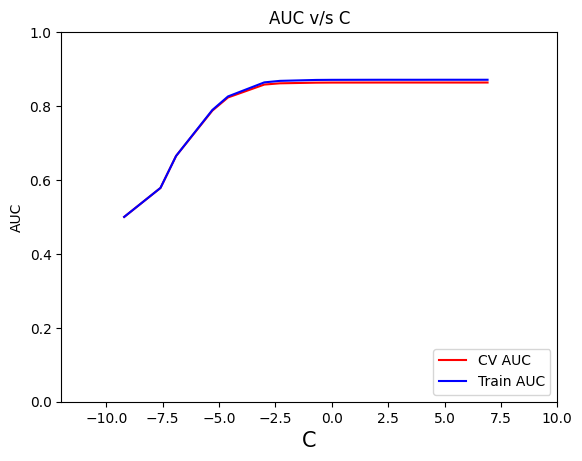

In [21]:

log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 1243  1641]
 [  572 16544]]


<Axes: >

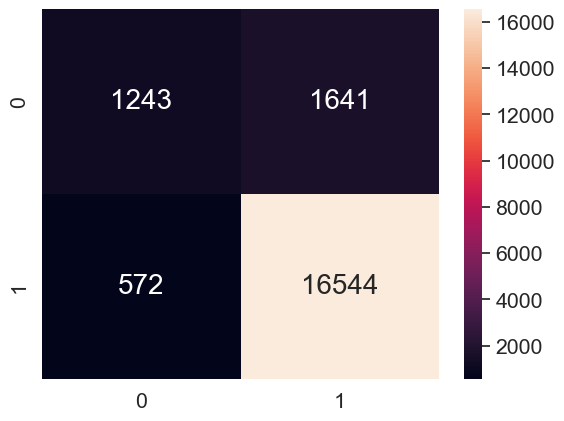

In [22]:
#confusion matrix on test cases
cm = confusion_matrix(y_test_bow,y_pred)
print(cm)

df_cm = pd.DataFrame(cm,range(2),range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_cm,annot=True,annot_kws={"size":20},fmt='g')

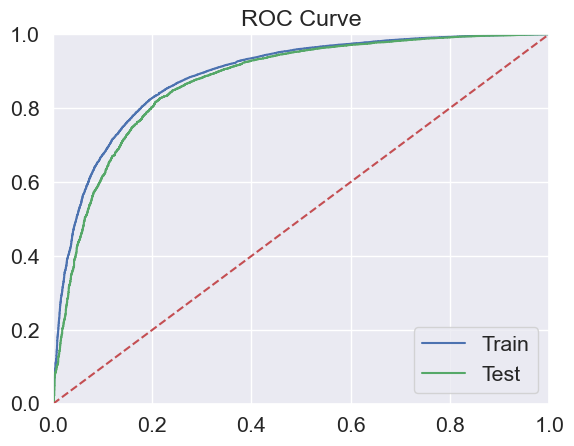

In [23]:
# Plotting roc curve on Train Data
pred_train = lrf.predict_proba(X_train_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_train_bow, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = lrf.predict_proba(X_test_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_test_bow, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [24]:
#Calculating sparsity on weight vector using optimal C value and L1 regularization
lrf = LogisticRegression(C=optimal_C, penalty= 'l1',solver="saga")
lrf.fit(X_train_bow,y_train_bow)
pred = lrf.predict(X_test_bow)
print("Size of the weight vector:",len(lrf.coef_[0]))
print("No. of Non Zero weights:",np.count_nonzero(lrf.coef_))
print('Sparsity =', (len(lrf.coef_[0])-np.count_nonzero(lrf.coef_)))

Size of the weight vector: 625
No. of Non Zero weights: 625
Sparsity = 0


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [25]:
# applying Logistic Regression with L2 regularization on BOW

In [26]:
# initializing Logistic Regression model with L2 regularisation
lr = LogisticRegression(penalty='l2',max_iter=10,solver='saga')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 1 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=2,return_train_score=True)

gscv.fit(X_train_bow[:50000],y_train_bow[:50000])

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag

Best C Value:  {'C': 50}
Best ROC AUC Score: 0.84870


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [27]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l2',C=optimal_C,solver='saga')
lrf.fit(X_train_bow,y_train_bow)

#predicting the class label using test data 
y_pred = lrf.predict(X_test_bow)
y_pred_proba = lrf.predict_proba(X_test_bow)[:,1]


#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_bow, y_pred_proba)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 50.000000 is 0.872927 ****


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


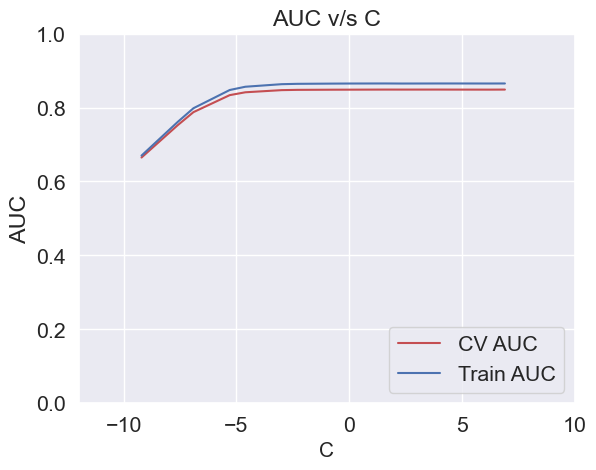

In [28]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 1243  1641]
 [  572 16544]]


<Axes: >

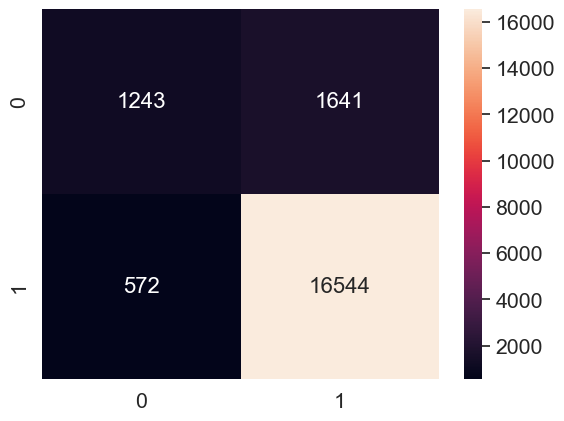

In [29]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_bow, y_pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### performing pertubation test (multicollinearty check) on BOW

In [30]:
weight1 = lrf.coef_[0]
print(weight1[:50])

[ 0.29447889 -0.13392955 -0.07002416  0.36137087  0.05094926 -0.22079286
 -0.46340372 -0.20695743 -0.35271094  0.22285982  0.05329058  0.11558457
  0.04658784  0.05886859  0.40599028  1.23641201 -0.05455247 -0.05245217
 -0.09834135 -0.21547795 -0.1860151  -0.14861393  0.07250439  0.02438398
  0.0028815   0.03307727  0.03214771  0.16511732 -0.53862216  0.03227672
  0.2740851  -0.72469171  1.04114132 -0.24911085 -0.21519526 -0.62300586
  0.05066352 -0.03943352  0.2797196   0.0842319  -0.02915208 -0.13697
 -0.1047442   0.62079442 -0.33339755 -0.07916585  1.222343    0.28756309
  0.01480462  0.47617725]


In [31]:
X_train_t = X_train_bow
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))

#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [32]:
#Training the model on the noise added dataset
lr = LogisticRegression(C= optimal_C, penalty= 'l1',solver='saga')
lr.fit(X_train_t,y_train_bow)
y_pred = lr.predict(X_test_bow)
print("Non Zero weights:",np.count_nonzero(lr.coef_))

Non Zero weights: 625


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [33]:
# weight vector after adding noise
weight2 = lr.coef_[0]
print(weight2[:50])

[ 0.49975315  0.07394494 -0.01949634  0.49909619  0.00956238 -0.23196554
 -0.56638718  0.04852648 -0.35825792  0.40328224 -0.04555236  0.21690285
  0.1637103   0.24323541  0.47207683  1.15300544 -0.0334649   0.01734058
 -0.1084106  -0.16824746 -0.23181066 -0.27446651  0.00159074  0.02480616
  0.28124152  0.12047543  0.17792448  0.09977144 -0.53471331  0.02490592
  0.38152598 -0.72561494  0.98913742 -0.09958957 -0.18358068 -0.77264812
  0.05685876 -0.08940388  0.35715287  0.06347345  0.04689304 -0.14128696
 -0.12484863  0.62681824 -0.19847934 -0.04910857  1.09350134  0.14627704
 -0.0485625   0.5820253 ]


In [34]:
#adding a small value to both the weight vectors
val=10**-6
weight1+=val
weight2+=val

In [35]:
# calculating the percentage change 
percent_change = abs((weight1 - weight2)/weight1) * 100
# no. of vectors that have a percentage change of more than 30%
print(percent_change.size)
print(percent_change[np.where(percent_change>30)].size)

625
331


In [36]:
# Feature importance on BOW

In [37]:
# Top 10 important features

In [38]:
#getting the feature names
feature_names = count_vect.get_feature_names_out()

#getting their corresponding log probabilities
coefs_with_fns = sorted(zip(lrf.coef_[0], feature_names))

#selecting the top 10 negative & positive features 
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
print("\t\t\tNegative\t\t\t\tPositive")
print("__________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

			Negative				Positive
__________________________________________________________________________________________________
	-1.0671	disappointed   				1.5774	excellent      
	-1.0354	unfortunately  				1.4590	delicious      
	-0.9747	money          				1.4125	perfect        
	-0.9673	waste          				1.3980	highly         
	-0.8591	excited        				1.3768	wonderful      
	-0.8445	idea           				1.2909	loves          
	-0.8096	cheap          				1.2781	pleased        
	-0.8058	unless         				1.2559	great          
	-0.7247	away           				1.2364	amazing        
	-0.6454	stick          				1.2223	best           


In [39]:
# Logistic Regression on TFIDF
# Applying Logistic Regression with L1 regularization on TFIDF

In [40]:
# split the dataset
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    x_tfidf, y_data, test_size=0.25, random_state=234)

In [41]:
# initializing Logistic Regression model with L1 regularisation
lr = LogisticRegression(penalty='l1',max_iter=10,solver='saga')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(X_train_tfidf[:30000],y_train_tfidf[:30000])

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag

Best C Value:  {'C': 1}
Best ROC AUC Score: 0.88780


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [42]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l1',C=optimal_C,solver='saga')
lrf.fit(X_train_tfidf,y_train_tfidf)

y_pred = lrf.predict(X_test_tfidf)
y_pred_proba = lrf.predict_proba(X_test_tfidf)[:,1]
auc_score = roc_auc_score(y_test_tfidf, y_pred_proba)

print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 1.000000 is 0.890622 ****


[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


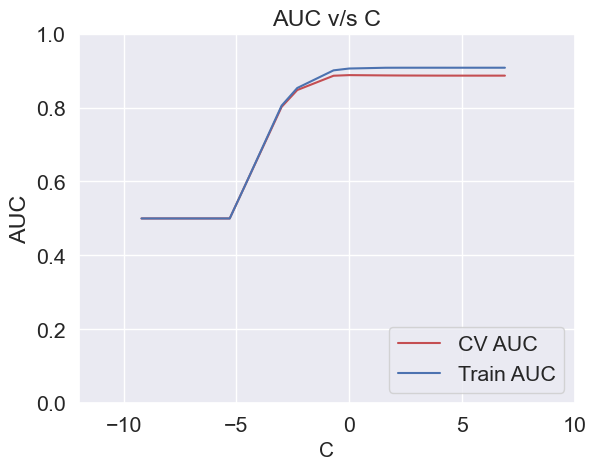

In [43]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 1243  1641]
 [  572 16544]]


<Axes: >

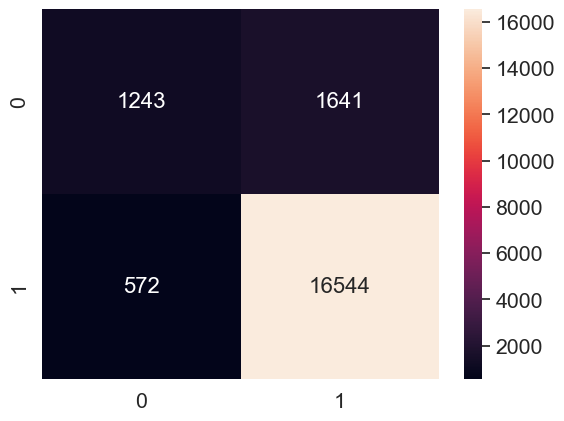

In [44]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_tfidf, pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [46]:
lr = LogisticRegression(penalty='l2',max_iter=10,solver='saga')

gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(X_train_tfidf[:30000],y_train_tfidf[:30000])

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag

Best C Value:  {'C': 1}
Best ROC AUC Score: 0.88829


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [47]:
optimal_C = gscv.best_params_['C']

lrf = LogisticRegression(penalty='l2',C=optimal_C,solver='saga')
lrf.fit(X_train_tfidf,y_train_tfidf)

y_pred = lrf.predict(X_test_tfidf)
y_pred_proba = lrf.predict_proba(X_test_tfidf)[:,1]
auc_score = roc_auc_score(y_test_tfidf, y_pred_proba)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))



**** Test roc_auc_score for C = 1.000000 is 0.890072 ****


In [ ]:
# AUC vs C plot

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


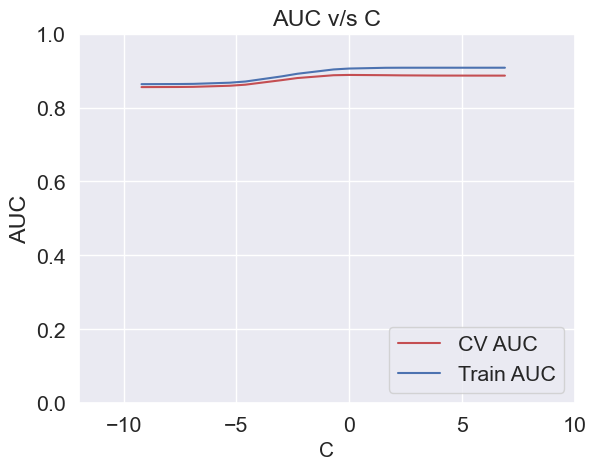

In [48]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 1143  1741]
 [  462 16654]]


<Axes: >

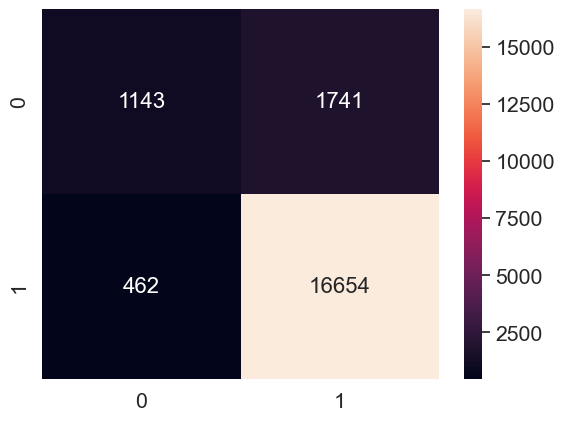

In [49]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_tfidf, y_pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [50]:
# Feature Importance of TFIDF
# Top 10 important features of positive & negative class

In [51]:
#getting the feature names
feature_names = tf_idf_vect.get_feature_names_out()

#getting their corresponding log probabilities
coefs_with_fns = sorted(zip(lrf.coef_[0], feature_names))

#selecting the top 10 negative & positive features 
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
print("\t\t\tNegative\t\t\t\tPositive")
print("__________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

			Negative				Positive
__________________________________________________________________________________________________
	-4.4856	disappointed   				8.0319	great          
	-3.9979	waste          				6.5292	best           
	-3.5627	unfortunately  				6.2957	delicious      
	-3.5256	money          				5.5149	excellent      
	-3.0602	away           				5.4126	perfect        
	-2.9285	even           				5.2870	highly         
	-2.8533	bad            				4.9963	wonderful      
	-2.8498	unless         				4.8700	love           
	-2.8123	stick          				4.8081	loves          
	-2.7328	maybe          				4.4429	amazing        


In [52]:
# Logistic Regression on Avg W2V
# Applying Logistic Regression with L1 regularization on AVG W2V

In [53]:
# split the dataset
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_w2v, y_data, test_size=0.25, random_state=234)

In [54]:
# initializing Logistic Regression model with L1 regularisation
lr = LogisticRegression(penalty='l1',max_iter=10,solver='saga')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(X_train_w2v[:30000],y_train_w2v[:30000])

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag

Best C Value:  {'C': 0.5}
Best ROC AUC Score: 0.88911


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [55]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l1',C=optimal_C,solver='saga')
lrf.fit(X_train_w2v,y_train_w2v)

y_pred = lrf.predict(X_test_w2v)
y_pred_proba = lrf.predict_proba(X_test_w2v)[:,1]
auc_score = roc_auc_score(y_test_w2v, y_pred_proba)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 0.500000 is 0.891944 ****


[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


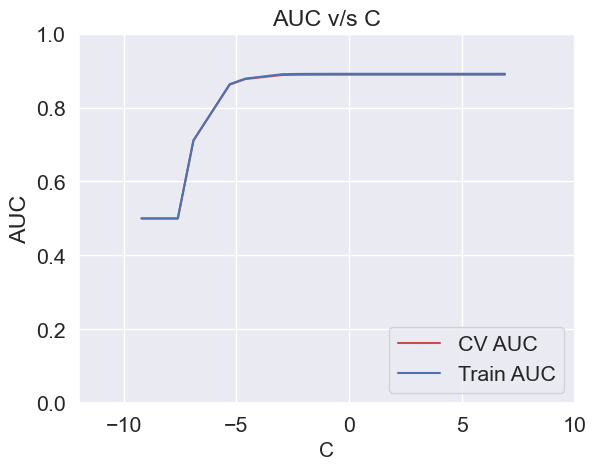

In [56]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 1149  1735]
 [  472 16644]]


<Axes: >

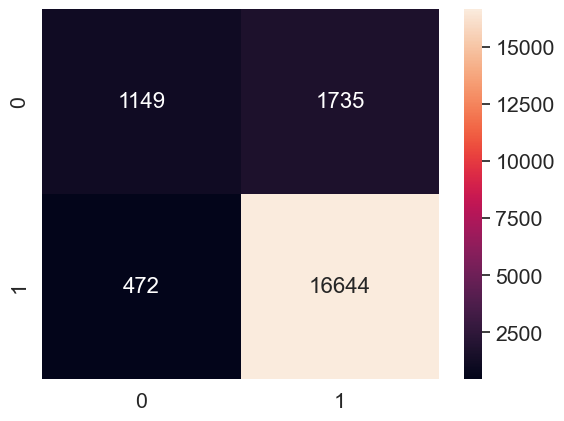

In [57]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_w2v, y_pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [59]:
lr = LogisticRegression(penalty='l2',max_iter=10,solver='saga')

gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(X_train_w2v[:30000],y_train_w2v[:30000])

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag

Best C Value:  {'C': 0.05}
Best ROC AUC Score: 0.88931


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [60]:
optimal_C = gscv.best_params_['C']

lrf = LogisticRegression(penalty='l2',C=optimal_C,solver='saga')
lrf.fit(X_train_w2v,y_train_w2v)

y_pred = lrf.predict(X_test_w2v)
y_pred_proba = lrf.predict_proba(X_test_w2v)[:,1]
auc_score = roc_auc_score(y_test_w2v, y_pred_proba)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))



**** Test roc_auc_score for C = 0.050000 is 0.892139 ****


In [61]:
# AUC vs C plot

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


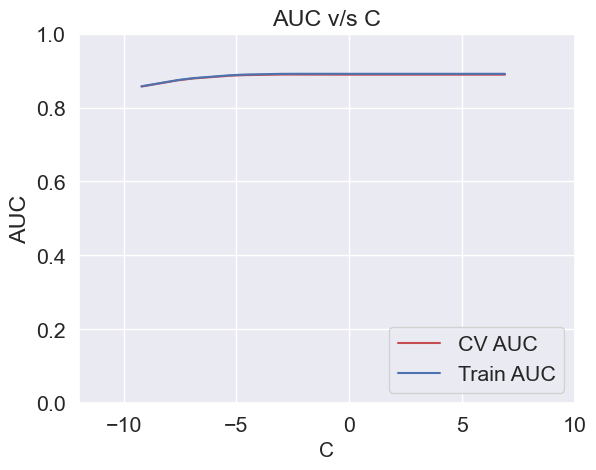

In [62]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[ 1124  1760]
 [  443 16673]]


<Axes: >

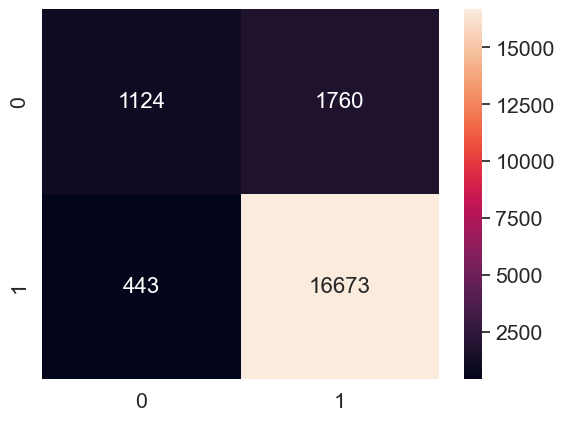

In [63]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_w2v, y_pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [64]:
# Logistic Regression on TFIDF W2V
# Applying Logistic Regression with L1 regularization on TFIDF W2V

In [65]:
# split the dataset
X_train_tfw2v, X_test_tfw2v, y_train_tfw2v, y_test_tfw2v = train_test_split(
    X_tfw2v, y_data, test_size=0.25, random_state=234)

In [66]:
# initializing Logistic Regression model with L1 regularisation
lr = LogisticRegression(penalty='l1',max_iter=10,solver='saga')

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(X_train_tfw2v[:30000],y_train_tfw2v[:30000])

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag

Best C Value:  {'C': 1}
Best ROC AUC Score: 0.86998


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [67]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
lrf = LogisticRegression(penalty='l1',C=optimal_C,solver='saga')
lrf.fit(X_train_tfw2v,y_train_tfw2v)

y_pred = lrf.predict(X_test_tfw2v)
y_pred_proba = lrf.predict_proba(X_test_tfw2v)[:,1]
auc_score = roc_auc_score(y_test_tfw2v, y_pred_proba)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 1.000000 is 0.872094 ****


[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


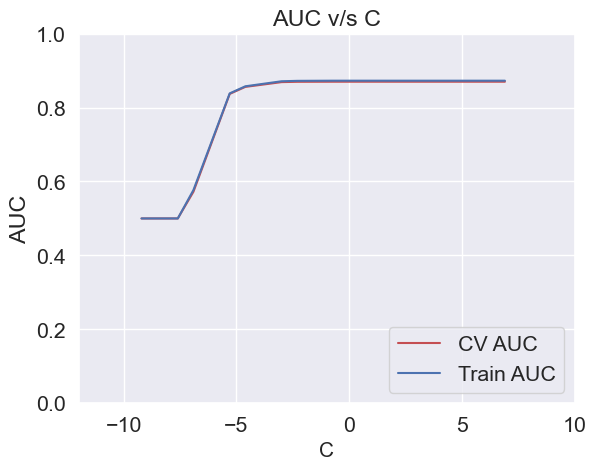

In [68]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[  948  1936]
 [  447 16669]]


<Axes: >

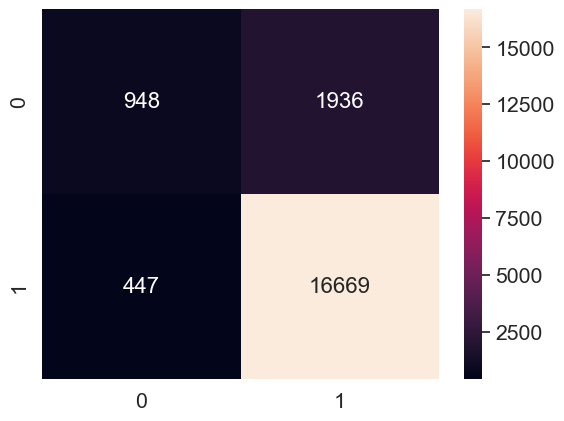

In [69]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_tfw2v, y_pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [71]:
lr = LogisticRegression(penalty='l2',max_iter=10,solver='saga')

gscv = GridSearchCV(lr,param_grid,scoring='roc_auc',cv=10,return_train_score=True)

gscv.fit(X_train_tfw2v[:30000],y_train_tfw2v[:30000])

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag

Best C Value:  {'C': 0.1}
Best ROC AUC Score: 0.87016


/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [74]:
optimal_C = gscv.best_params_['C']

lrf = LogisticRegression(penalty='l2',max_iter=1000,C=optimal_C,solver='saga')
lrf.fit(X_train_tfw2v,y_train_tfw2v)

y_pred = lrf.predict(X_test_tfw2v)
y_pred_proba = lrf.predict_proba(X_test_tfw2v)[:,1]
auc_score = roc_auc_score(y_test_tfw2v, y_pred_proba)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))



**** Test roc_auc_score for C = 0.100000 is 0.872350 ****


In [75]:
# AUC vs C plot

[6.907755278982137, 6.214608098422191, 4.605170185988092, 3.912023005428146, 2.302585092994046, 1.6094379124341003, 0.0, -0.6931471805599453, -2.3025850929940455, -2.995732273553991, -4.605170185988091, -5.298317366548036, -6.907755278982137, -7.600902459542082, -9.210340371976182]


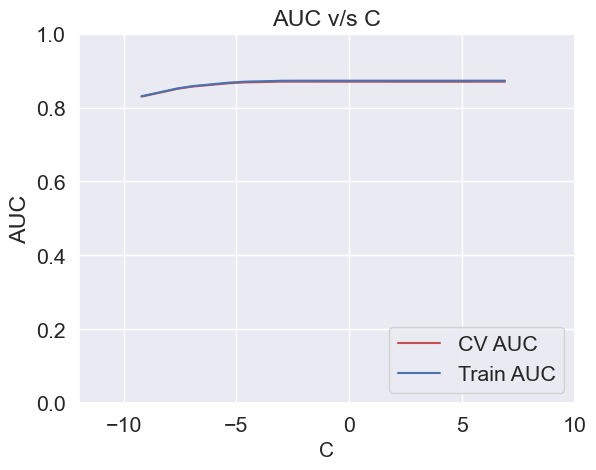

In [76]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in C_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s C')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

[[  926  1958]
 [  437 16679]]


<Axes: >

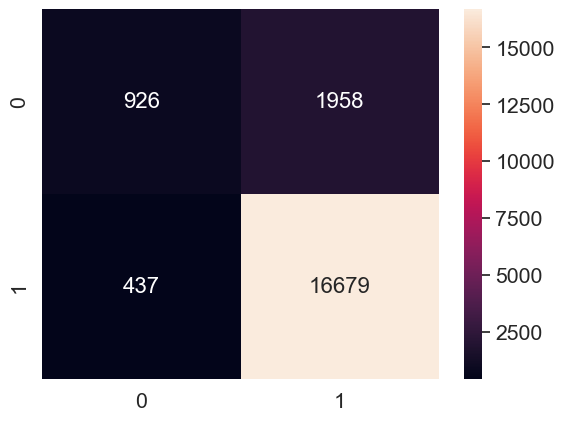

In [77]:
#plotting confusion matrix as heatmap
cm = confusion_matrix(y_test_tfw2v, y_pred)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')